In [206]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme('paper')


import astropy.constants as const
import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Simhei']  #显示中文
plt.rcParams['axes.unicode_minus']=False    #显示负号
%config InlineBackend.figure_format = 'retina'
# plt.style.use('ggplot')
# plt.rcParams['text.usetex'] = True

from scipy.interpolate import lagrange
from scipy.interpolate import CubicSpline   # 三次样条插值
from scipy.signal import find_peaks
from peakutils import baseline

import os
path='./figs/'
os.makedirs(path,exist_ok=True) 

# 理论公式

理论公式借用了 `astropy` 进行了带单位运算， 公式采用自然单位制。

In [207]:
def gamma_out_ratio(theta,omega_in):
    return 1/(1+omega_in/(const.m_e*const.c**2)*(1-np.cos(theta)))

def Klein_Nishin_formula(theta,omega):
    '''
    return d\\sigma/d\\Omega
    '''
    
    omega_p_over_omega = gamma_out_ratio(theta,omega)
    diff_cross = 1/2*const.alpha**2/(const.m_e*const.c**2)**2*omega_p_over_omega**2*(omega_p_over_omega+1/omega_p_over_omega-np.sin(theta)**2)
    return (diff_cross*(const.h*const.c)**2).to(u.barn)

# 能谱数据处理

### 效率校刻

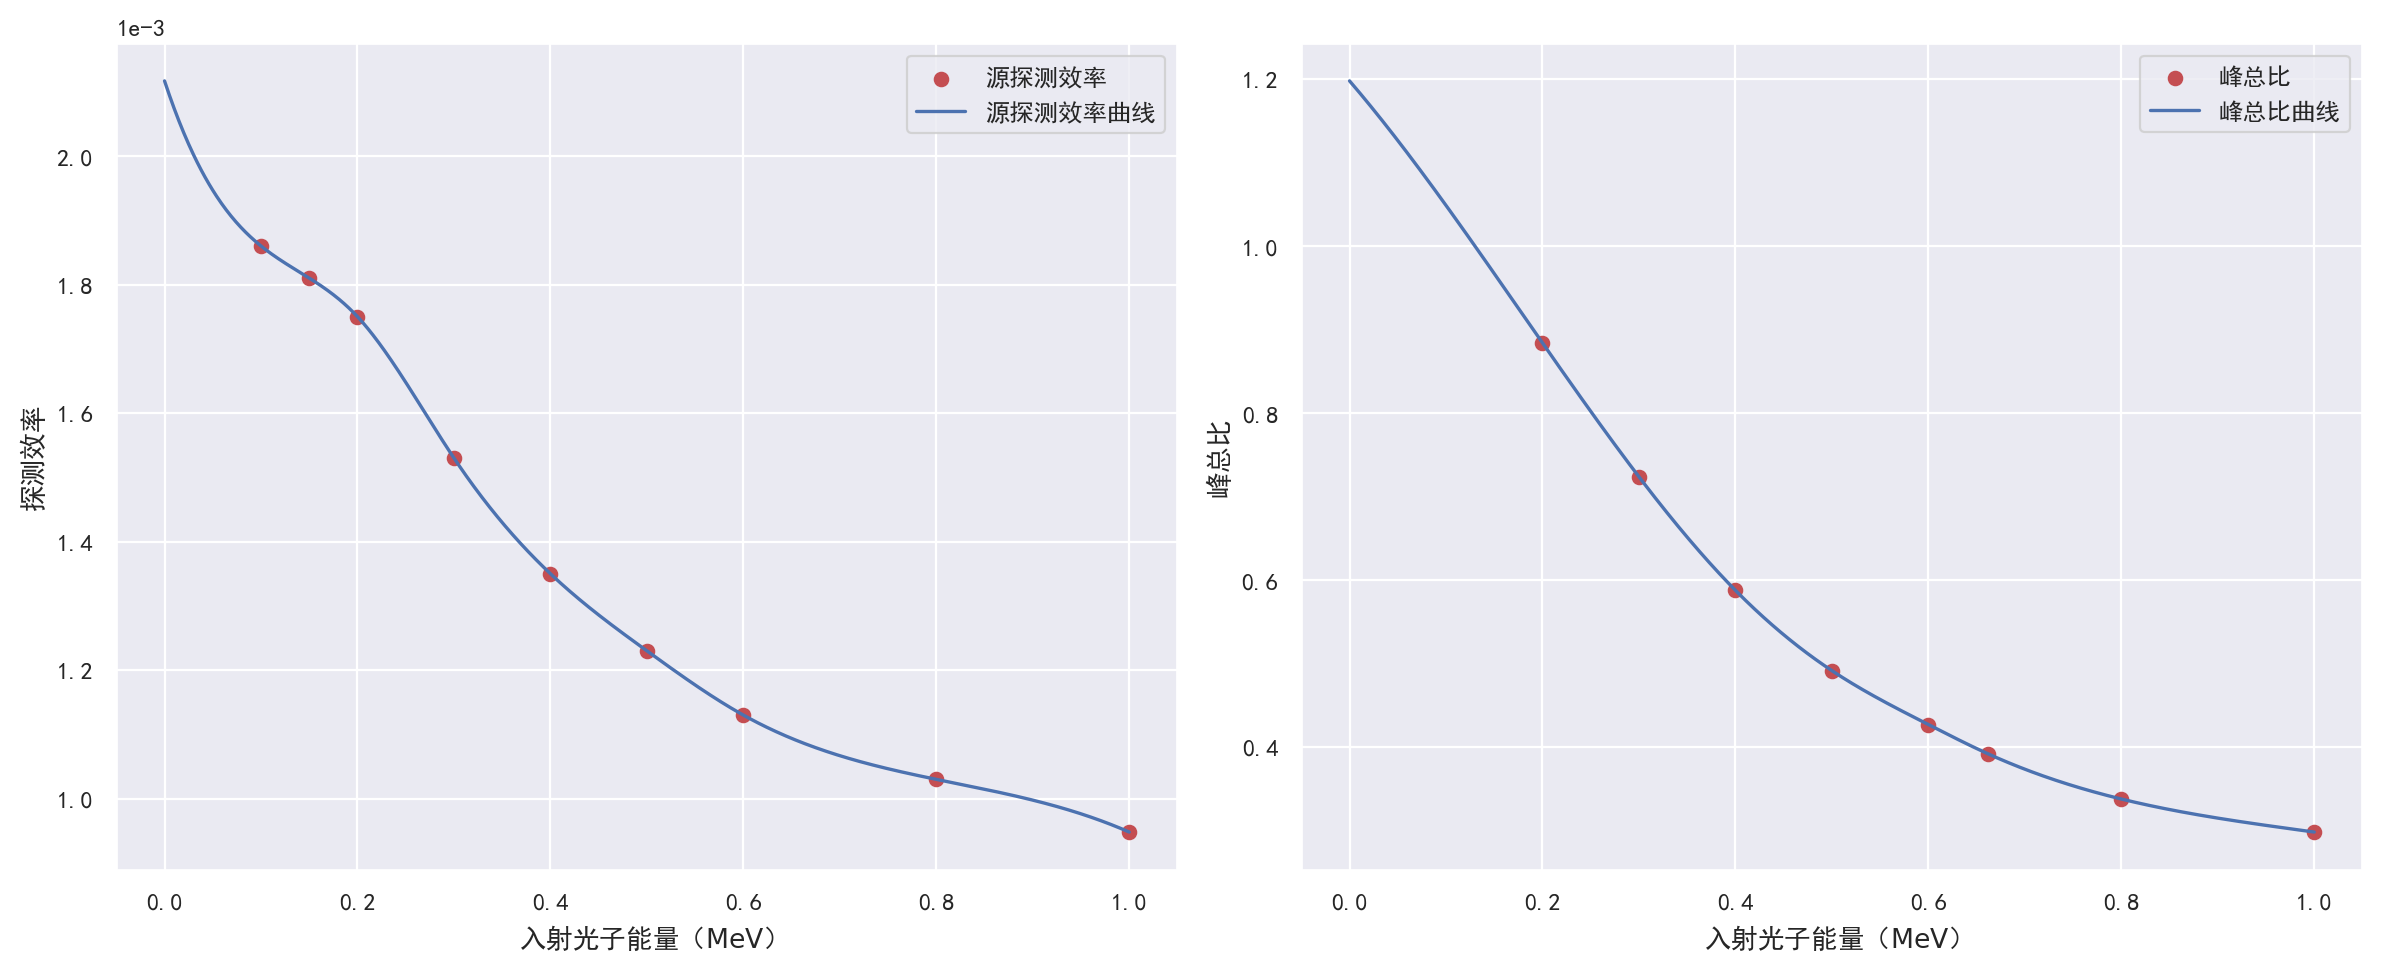

In [208]:
eta_data = pd.read_excel('detector efficience.xlsx',sheet_name='eta')
R_data = pd.read_excel('detector efficience.xlsx',sheet_name='R')

ene_to_eta = CubicSpline(eta_data['E(MeV)'],eta_data['eta(*1e4)'].apply(lambda x:x*1e-4))
ene_to_R = CubicSpline(R_data['E(MeV)'],R_data['R'])
# ene_to_eta = lagrange(eta_data['E(MeV)'],eta_data['eta(*1e4)'].apply(lambda x:x*1e-4))
# ene_to_R = lagrange(R_data['E(MeV)'],R_data['R'])

ene_plot = np.linspace(0,1,1001)
fig,ax=plt.subplots(1,2,figsize = (12,5))
ax[0].scatter(eta_data['E(MeV)'],eta_data['eta(*1e4)'].apply(lambda x:x*1e-4),
              c='r',label = '源探测效率')
ax[0].plot(ene_plot,ene_to_eta(ene_plot),
           c = 'b',label = '源探测效率曲线')
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0].set_xlabel(r'入射光子能量（$\mathrm{MeV}$）')
ax[0].set_ylabel(r'探测效率')
ax[0].legend()
ax[1].scatter(R_data['E(MeV)'],R_data['R'],
              c='r',label = '峰总比')
ax[1].plot(ene_plot,ene_to_R(ene_plot),
           c='b',label = '峰总比曲线')
ax[1].set_xlabel(r'入射光子能量（$\mathrm{MeV}$）')
ax[1].set_ylabel(r'峰总比')
ax[1].legend()
# fig.suptitle('探测效率插值曲线（三次样条插值）')
fig.tight_layout()
fig.savefig(path+'efficience_interplo.pdf')

### 数据提取

In [209]:
datapath = './data/'
files = os.listdir(datapath)

txtfiles = []
for file in files:
    _,extension= os.path.splitext(file)
    if extension=='.txt':
        txtfiles.append(file)
txtfiles[:] = [txtfiles[-1]] + txtfiles[:-1]
txtfiles[3] , txtfiles[2] = txtfiles[2] , txtfiles[3]
txtfiles[4] , txtfiles[6] = txtfiles[6] , txtfiles[4]

txtfiles
# txtfiles

['22Nazx_txt.txt',
 '137Cszx_txt.txt',
 '137Cs_120_txt.txt',
 '137Cs_100_txt.txt',
 '137Cs_80_txt.txt',
 '137Cs_60_txt.txt',
 '137Cs_40_txt.txt',
 '137_Cs_20_txt.txt']

In [210]:
datas = [pd.read_csv(datapath+file, sep='\t')['1'].values for file in txtfiles]
_datas_Energy_scale = datas[:2]
_datas_Full_Energy = datas[2:]

### 能量刻度

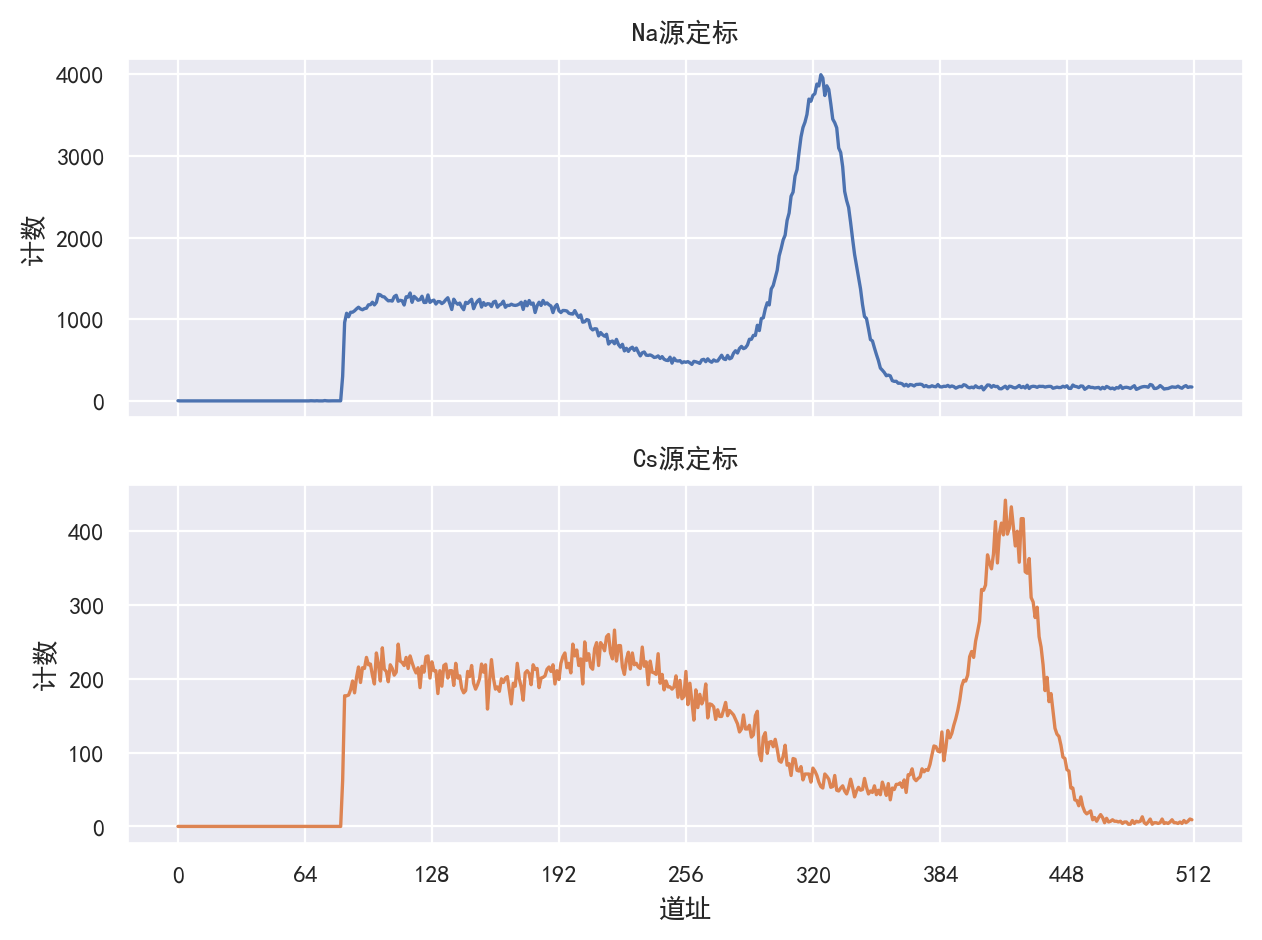

In [211]:
datas_Energy_scale=pd.DataFrame(dict(zip(['22Na-Energy-Scale','137Cs-Energy-Scale'],
                                         _datas_Energy_scale)))
axes = datas_Energy_scale.plot(subplots=True,legend=False)

axes[1].set_xlabel('道址')
axes[1].set_xticks(np.linspace(0,512,9))

axes[0].set_ylabel('计数')
axes[0].set_title('Na源定标')
axes[1].set_ylabel('计数')
axes[1].set_title('Cs源定标')
fig = axes[0].get_figure()
fig.tight_layout()
fig.savefig(path+'Energy_Scale_origin.pdf')

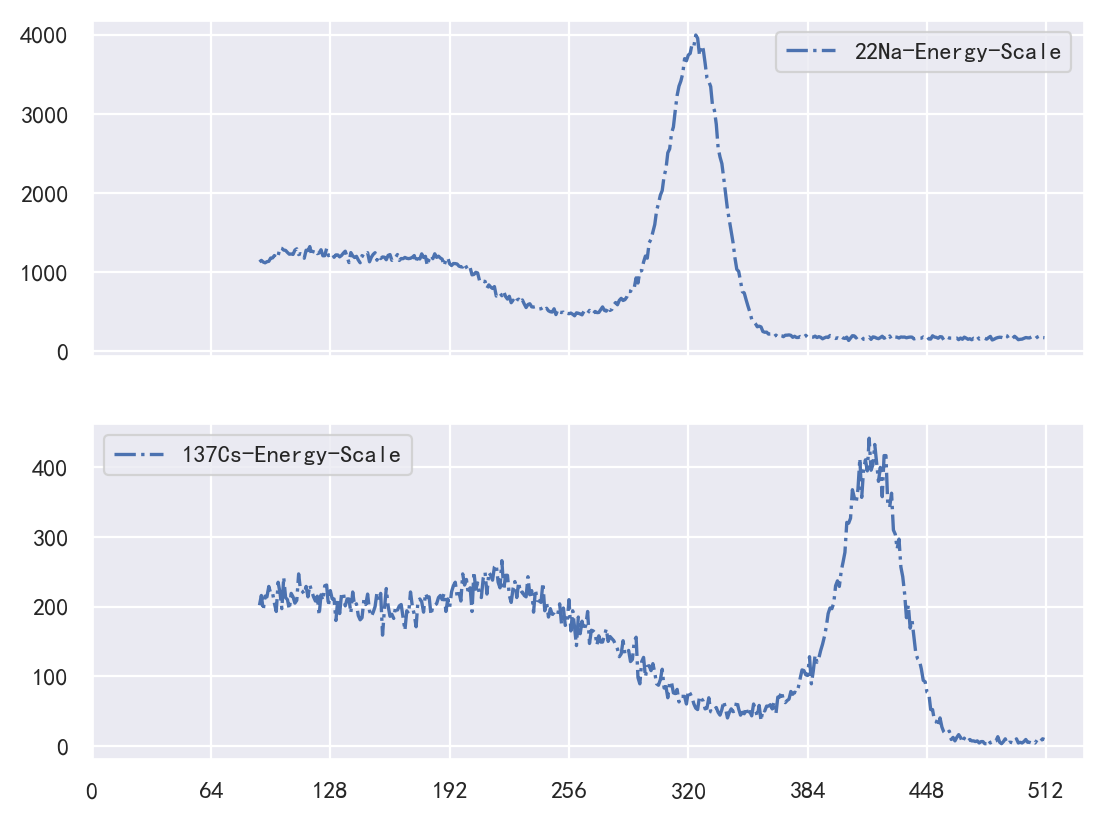

In [212]:
drop1 = 90
datas_Energy_scale = datas_Energy_scale.drop(np.arange(0,drop1,1))
axes = datas_Energy_scale.plot(subplots=True,color='b',style='-.')
axes[1].set_xticks(np.linspace(0,512,9))
fig = axes[0].get_figure()

#### 基线

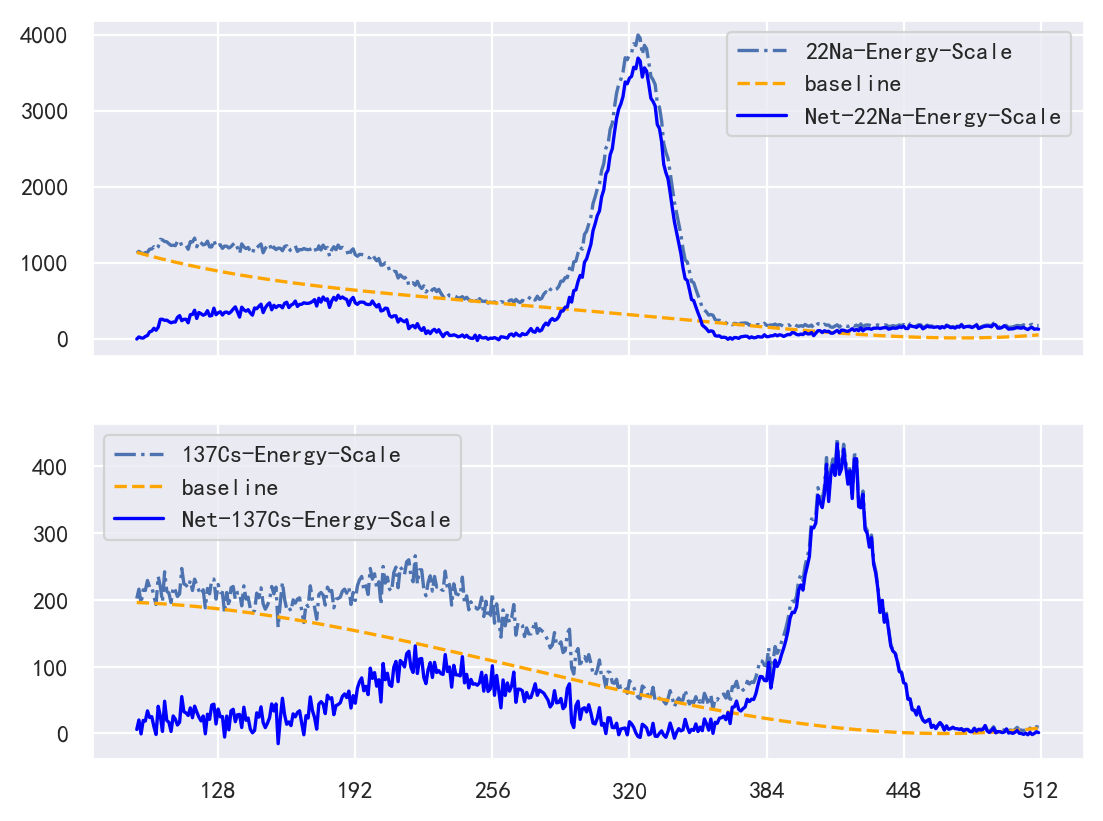

In [213]:
bl1 = baseline(datas_Energy_scale['22Na-Energy-Scale'],
              deg=4)
datas_Energy_scale['Net-22Na-Energy-Scale'] = datas_Energy_scale['22Na-Energy-Scale'].values-bl1
bl2 = baseline(datas_Energy_scale['137Cs-Energy-Scale'],
              deg=3)
datas_Energy_scale['Net-137Cs-Energy-Scale'] = datas_Energy_scale['137Cs-Energy-Scale'].values-bl2

axes[0].plot(datas_Energy_scale.index.values,bl1,color='orange',
             label = 'baseline', linestyle='dashed')
datas_Energy_scale.plot(y='Net-22Na-Energy-Scale',ax=axes[0],color='blue')
axes[1].plot(datas_Energy_scale.index.values,bl2,color='orange',
             label = 'baseline', linestyle='dashed')
datas_Energy_scale.plot(y='Net-137Cs-Energy-Scale',ax=axes[1],color='blue')


for ax in axes:
    le = ax.legend()
    # le.get_texts()[0].set_text('sdf')
fig

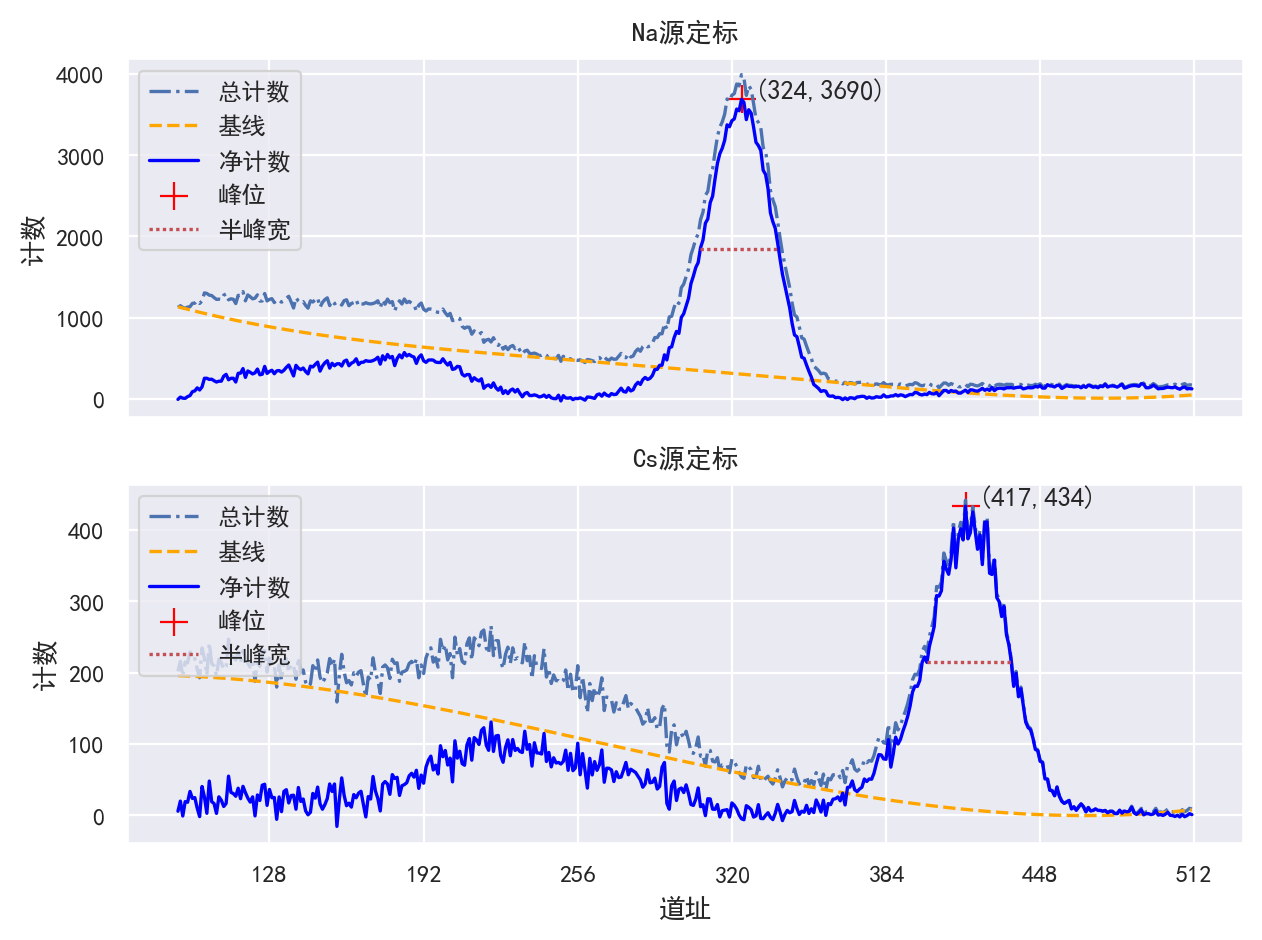

,sourse,peak,width
0,Na,324,32.525339
1,Cs,417,34.949287


In [214]:
# peak1
peaks1,info1 = find_peaks(datas_Energy_scale['Net-22Na-Energy-Scale'],
          height=2000,
          width=30,
          prominence=3000)
sns.scatterplot(datas_Energy_scale.iloc[peaks1],
                x=datas_Energy_scale.index[peaks1],
                y='Net-22Na-Energy-Scale',ax=axes[0],
                label='Peak',color='red',marker='+',s=100)
axes[0].text(datas_Energy_scale.index[peaks1[0]]+5,
              info1['peak_heights'][0],
              f'({datas_Energy_scale.index[peaks1[0]]},{info1['peak_heights'][0]:.0f})')

axes[0].hlines(info1['width_heights'],info1['left_ips']+drop1,info1['right_ips']+drop1,
               linestyle=(0, (1, 1)),label='FWHM',color='r')
# peak2
peaks2,info2 = find_peaks(datas_Energy_scale['Net-137Cs-Energy-Scale'],
          height=200,
          width=30,
          prominence=400)
sns.scatterplot(datas_Energy_scale.iloc[peaks2],
                x=datas_Energy_scale.index[peaks2],
                y='Net-137Cs-Energy-Scale',ax=axes[1],
                label='Peak',color='red',marker='+',s=100)
axes[1].hlines(info2['width_heights'],info2['left_ips']+drop1,info2['right_ips']+drop1,
               linestyle=(0, (1, 1)),label='FWHM',color='r')
axes[1].text(datas_Energy_scale.index[peaks2[0]]+5,
              info2['peak_heights'][0],
              f'({datas_Energy_scale.index[peaks2[0]]},{info2['peak_heights'][0]:.0f})')

for ax in axes:
    le = ax.legend(['总计数','基线','净计数','峰位','半峰宽'],loc='upper left')

axes[1].set_xlabel('道址')

axes[0].set_ylabel('计数')
axes[0].set_title('Na源定标')
axes[1].set_ylabel('计数')
axes[1].set_title('Cs源定标')
fig.tight_layout()
fig.savefig(path+'Energy_Scale.pdf')
display(fig)

ene_sca_result = pd.DataFrame({'sourse':['Na','Cs'],
                       'peak':[datas_Energy_scale.index[peaks1[0]],datas_Energy_scale.index[peaks2[0]]],
                       'width':[info1['widths'][0],info2['widths'][0]]})
display(ene_sca_result)

In [215]:
formatters = {'width':lambda x: f'{x:.1f}'}
print(ene_sca_result.to_latex(header=['放射源','峰值','半峰宽'],
                              formatters=formatters,
                              index=False,
                              column_format='ccc',
                              caption='标准源全能峰位置',
                              label = 'tab:standard_source',
                              position='H'))

\begin{table}[H]
\caption{标准源全能峰位置}
\label{tab:standard_source}
\begin{tabular}{ccc}
\toprule
放射源 & 峰值 & 半峰宽 \\
\midrule
Na & 324 & 32.5 \\
Cs & 417 & 34.9 \\
\bottomrule
\end{tabular}
\end{table}



#### 能量刻度结果

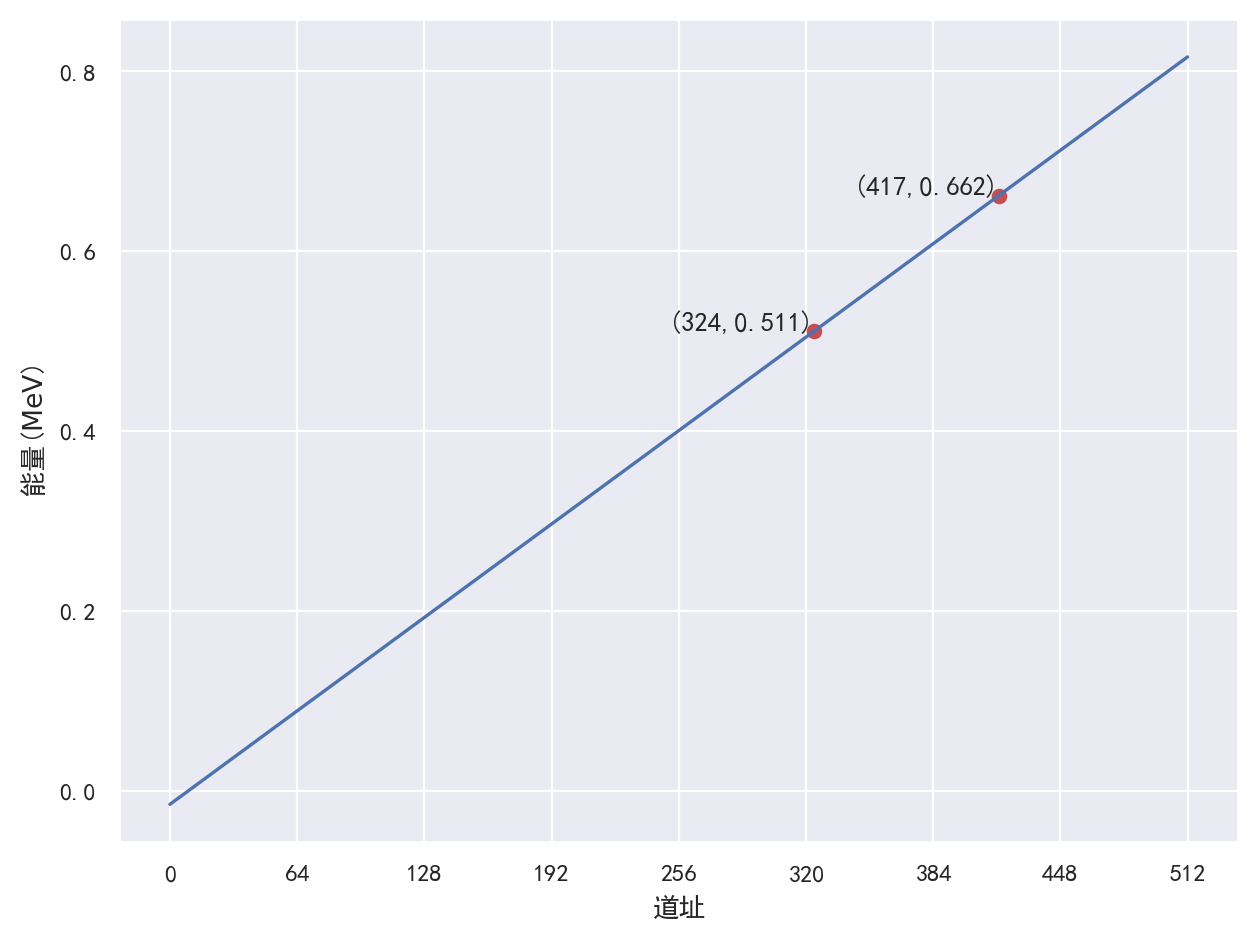

In [216]:
Ene_Na22 = 0.511*u.MeV
Ene_Cs137 = 0.662*u.MeV
Ene = [Ene_Na22.value,Ene_Cs137.value]
dao = ene_sca_result['peak']
dao_to_Ene = lagrange(dao,Ene)
x = np.linspace(0,512,512)
plt.plot(x,dao_to_Ene(x),'b')
plt.scatter(dao,Ene,c='r')
plt.text(dao[0],Ene[0],f'({dao[0]},{Ene[0]})',ha='right')
plt.text(dao[1],Ene[1],f'({dao[1]},{Ene[1]})',ha='right')
plt.xticks(np.linspace(0,512,9))
plt.xlabel('道址')
plt.ylabel(r'能量($\mathrm{MeV}$)')
plt.tight_layout()
plt.grid(True)
plt.savefig(path+'calibration.pdf')
plt.show()

In [217]:
print(dao_to_Ene)

 
0.001624 x - 0.01506


### 能谱数据

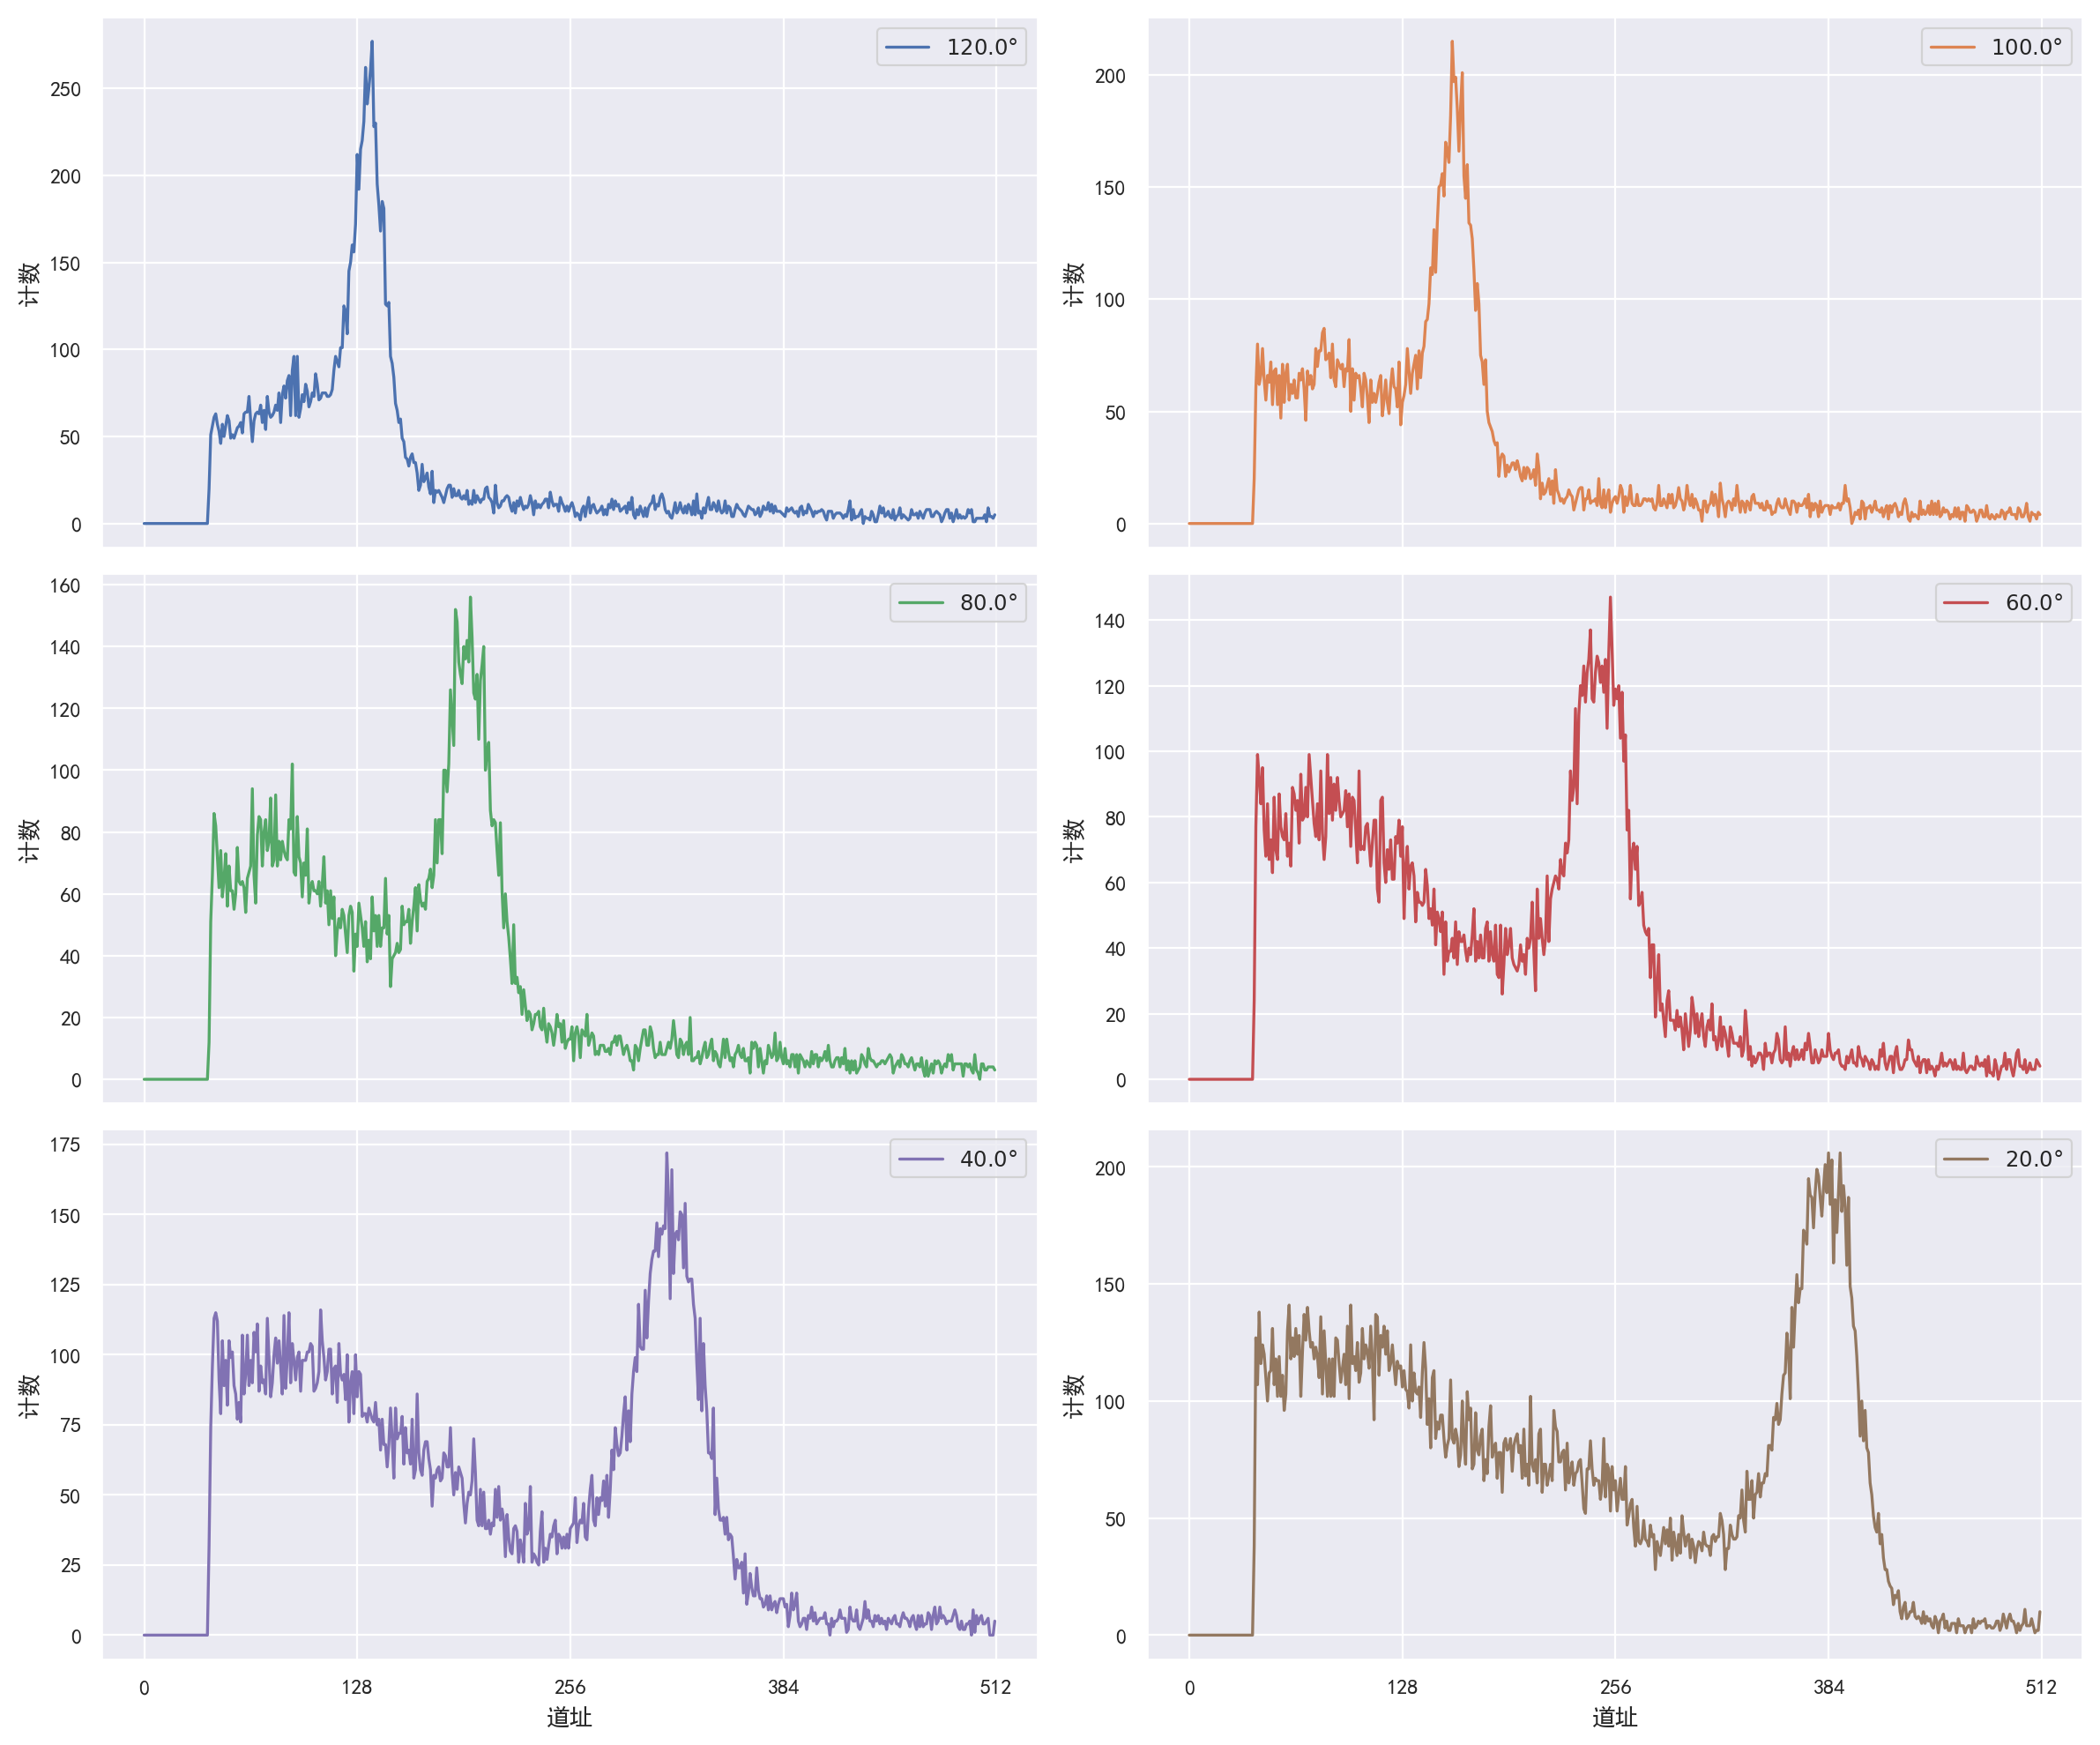

In [218]:
datas_Full_Energy=pd.DataFrame(dict(zip([fr'${i}\degree$' for i in np.linspace(120,20,6)],
                                         _datas_Full_Energy)))
axes = datas_Full_Energy.plot(subplots=True,figsize=(12,10),layout=[3,2])
axes = axes.flatten()
axes[0].set_xticks(np.linspace(0,512,5))
for ax in axes:
    ax.set_ylabel('计数')


axes[-1].set_xlabel('道址')
axes[-2].set_xlabel('道址')
fig = axes[0].get_figure()
fig.tight_layout()
fig.savefig(path+'crs_origin.pdf')
None

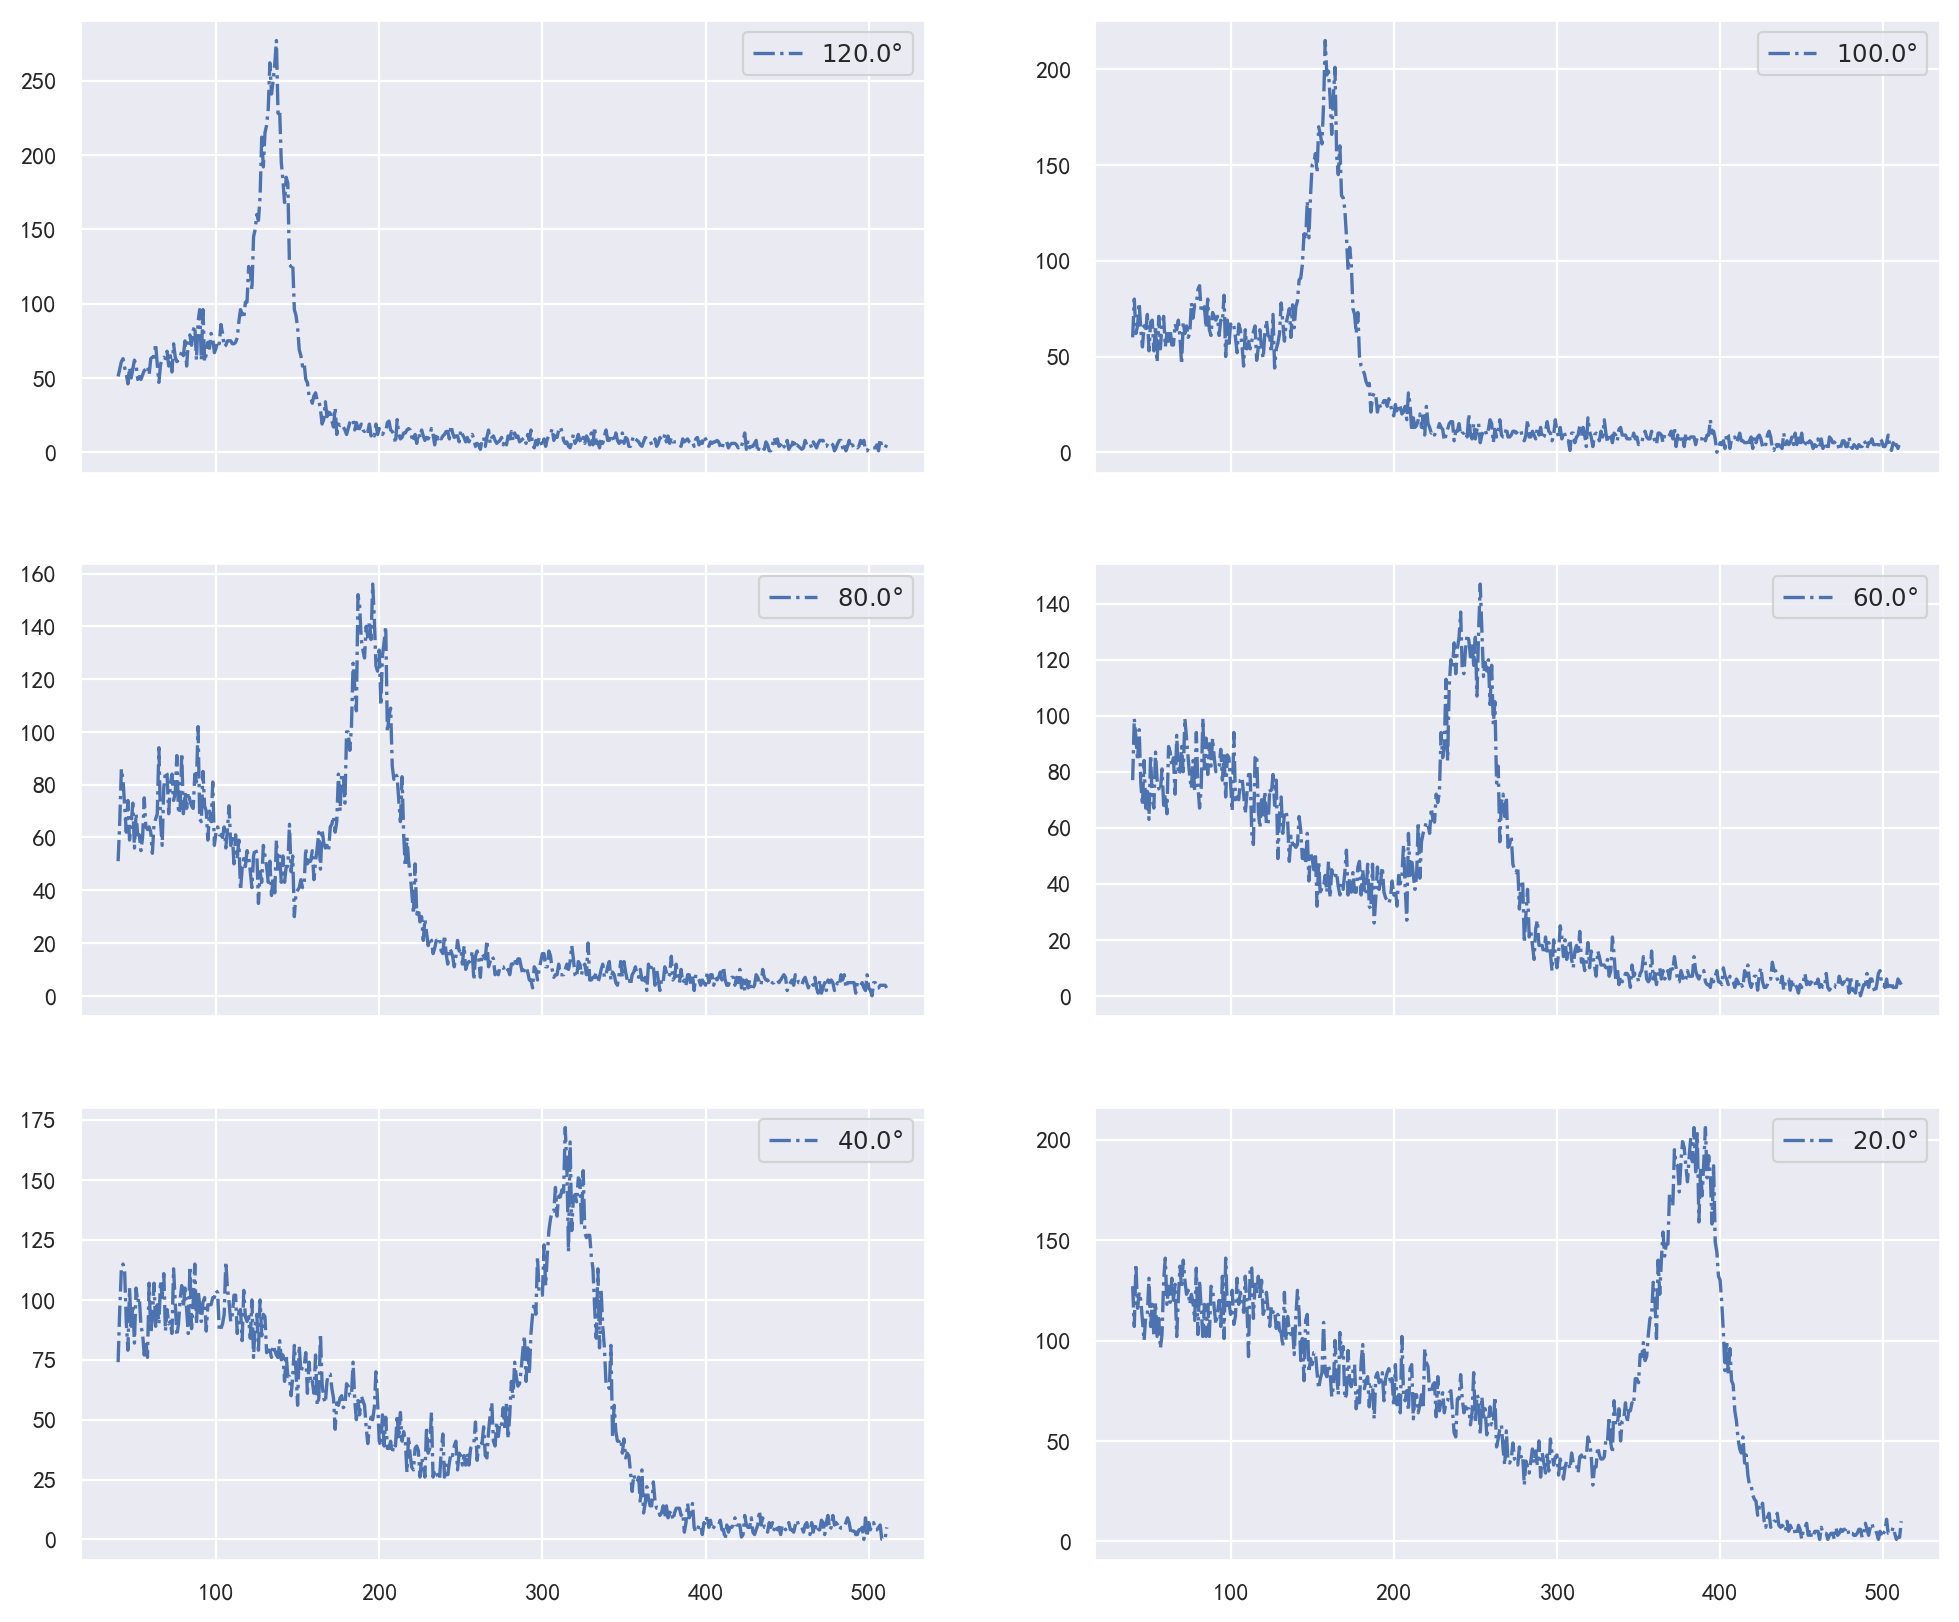

In [219]:
drop2 = 40
datas_Full_Energy = datas_Full_Energy.drop([i for i in range(drop2)])
FE_axes = datas_Full_Energy.plot(subplots=True,layout=[3,2],figsize=(12,10),color='b',style='-.')
FE_axes = FE_axes.flatten()
FE_fig = FE_axes[0].get_figure()

#### 基线

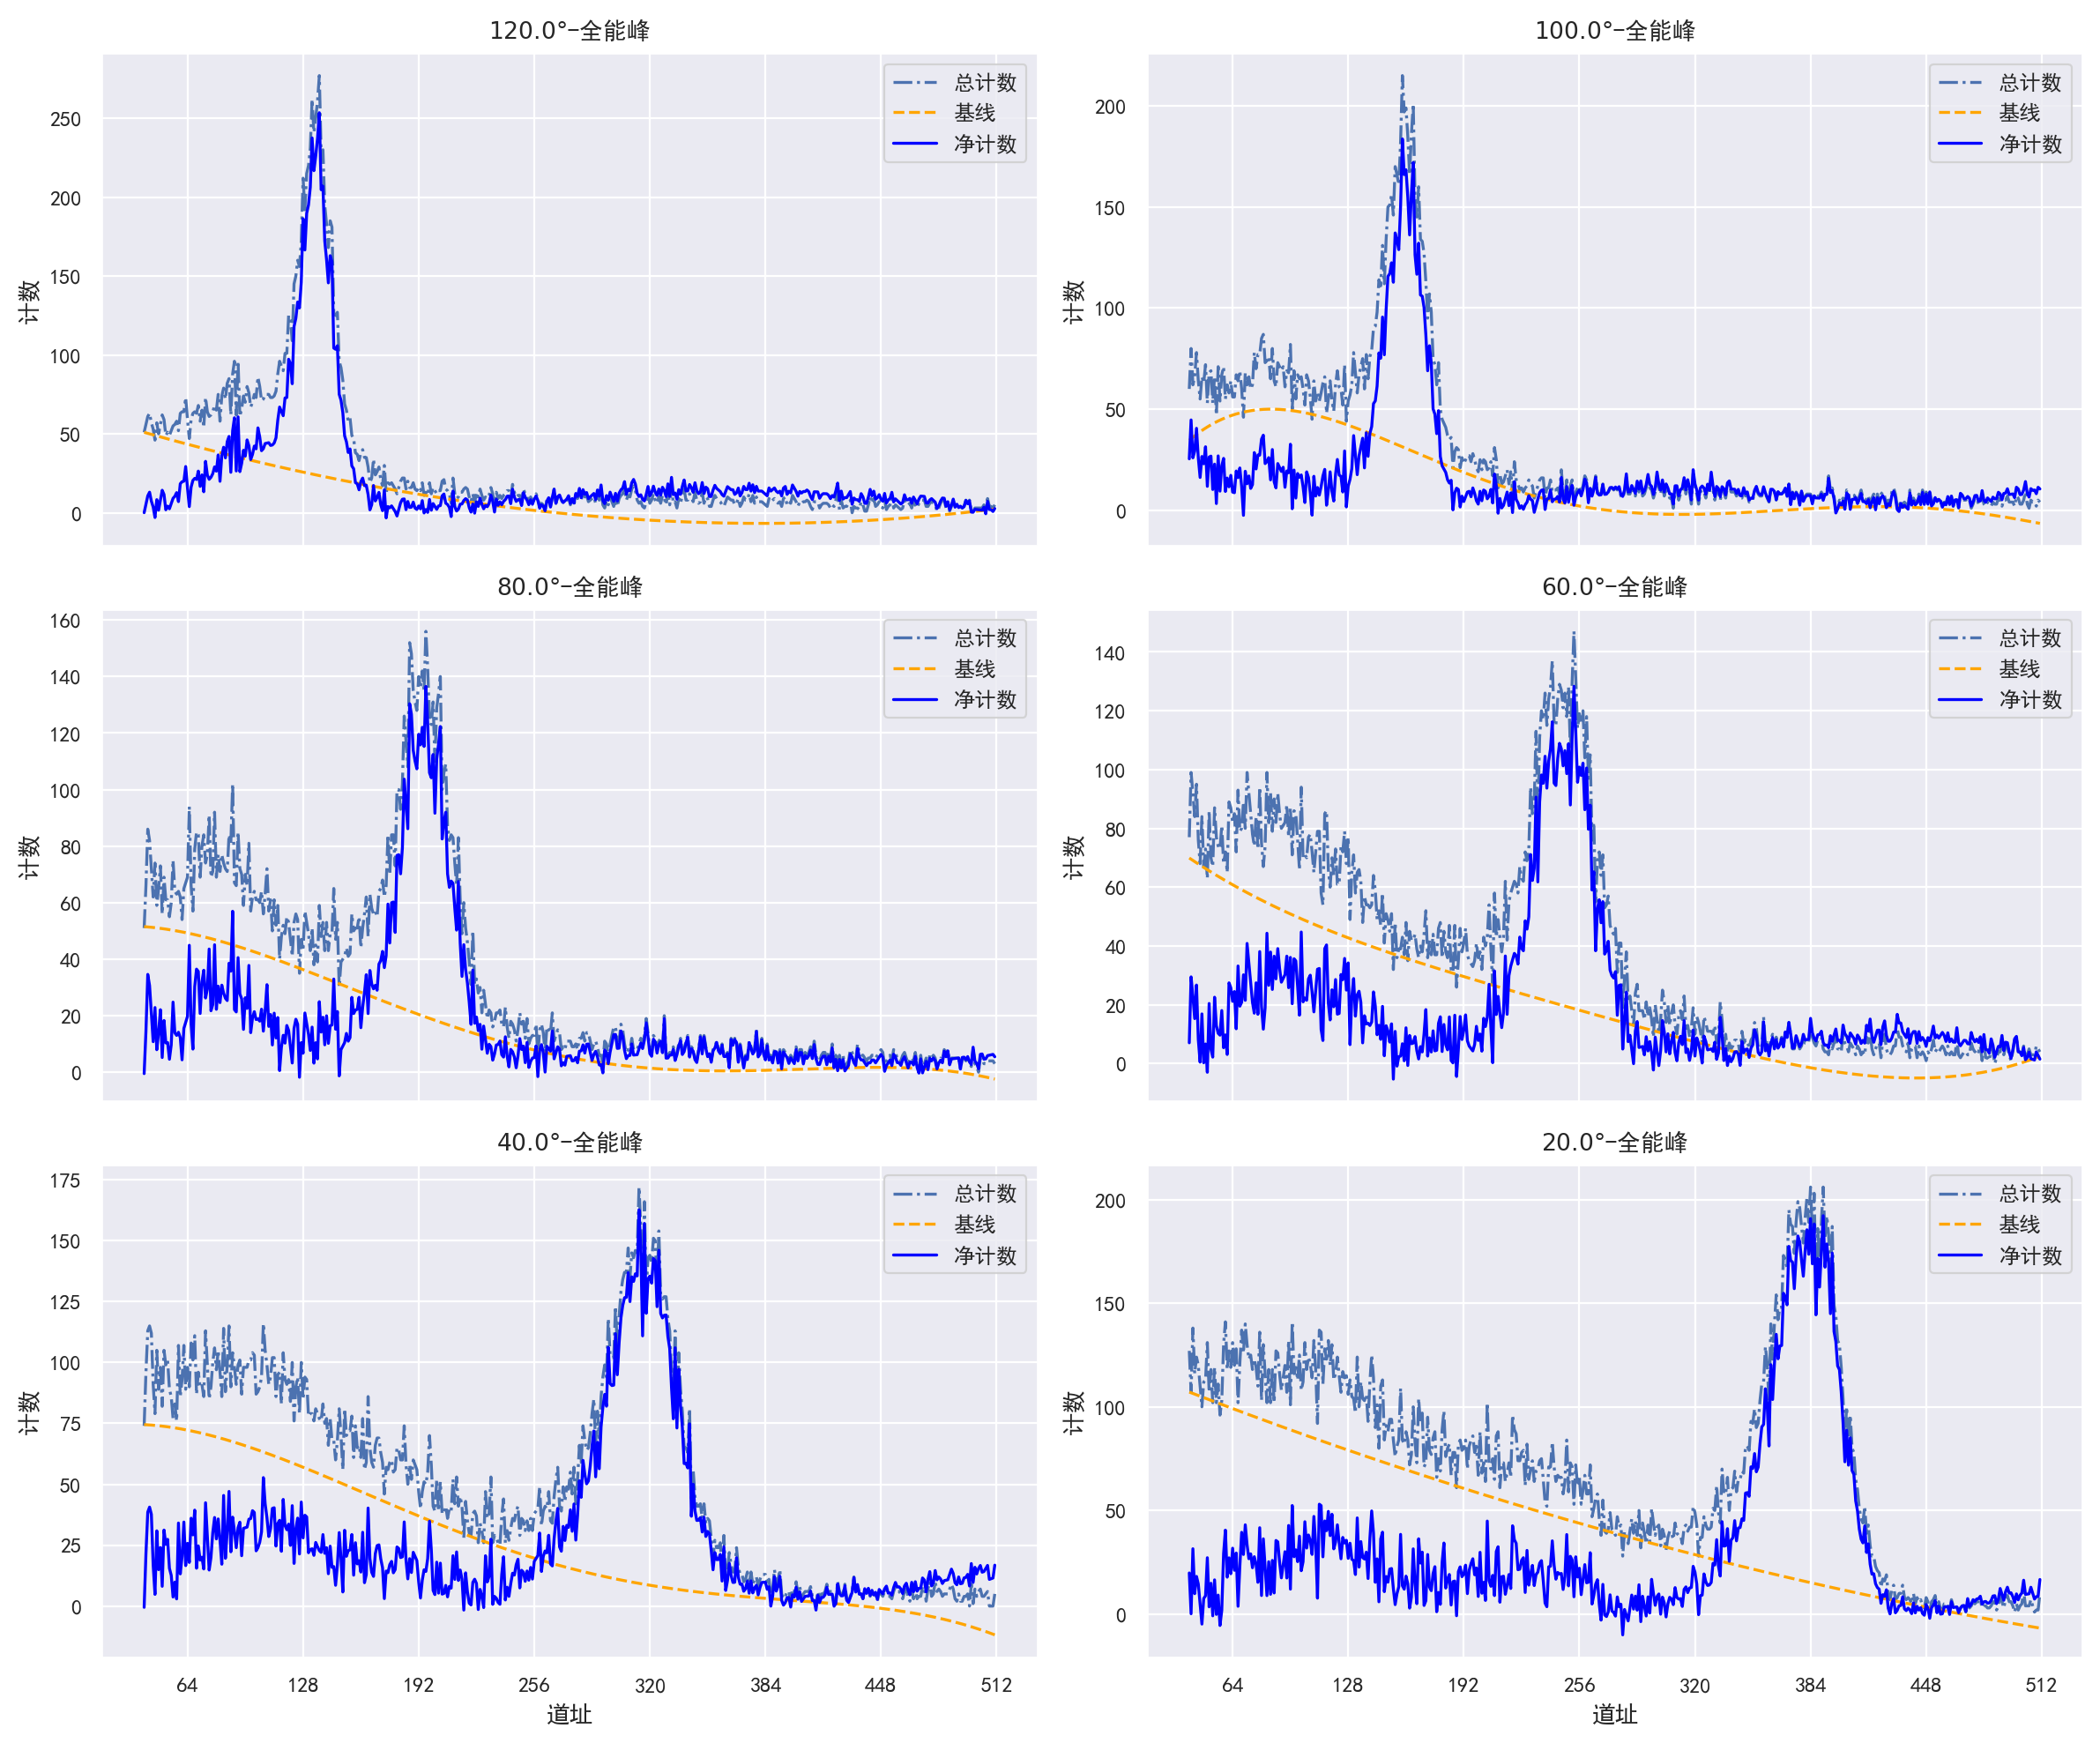

In [220]:
degs = [3,5,4,4,4,2]
bls =[baseline(datas_Full_Energy[column],deg = deg) for column,deg in \
      zip(datas_Full_Energy.columns.values,degs)]

for ax,bl,column in zip(FE_axes,bls,datas_Full_Energy.columns.values):
    ax.plot(datas_Full_Energy.index,bl,label = 'baseline',linestyle='dashed',color='orange')
    datas_Full_Energy['Net'+column] = datas_Full_Energy[column]-bl
    ax.plot(datas_Full_Energy.index,datas_Full_Energy['Net'+column],
            label='Net'+column,color = 'blue')


for ax,column in zip(FE_axes,datas_Full_Energy.columns[:6]):
    ax.legend(['总计数','基线','净计数'])
    ax.set_title(column+'-全能峰')
    ax.set_ylabel('计数')

FE_axes[-1].set_xlabel('道址')
FE_axes[-2].set_xlabel('道址')
FE_axes[0].set_xticks(np.linspace(64,512,8))

    # le.get_texts()[0].set_text('sdf')
FE_fig.tight_layout()
FE_fig.savefig(path+'Full_Energy_Peak-Baseline.pdf')
FE_fig

In [221]:
Net_Full_Energy = datas_Full_Energy[datas_Full_Energy.columns[6:]]
Net_Full_Energy

,Net$120.0\degree$,Net$100.0\degree$,Net$80.0\degree$,Net$60.0\degree$,Net$40.0\degree$,Net$20.0\degree$
40,0.052577,25.408092,-0.503733,7.084282,-0.500677,19.872990
41,5.376182,44.649984,14.548187,29.496102,21.539952,0.209166
42,10.698955,25.914829,34.604121,22.904827,38.585696,31.544940
43,13.020895,29.202320,30.664021,15.310486,40.636498,9.880313
44,7.342002,40.512154,20.727842,26.713107,37.692301,18.215283
...,...,...,...,...,...,...
507,7.224266,9.833125,5.858961,1.453677,16.698416,10.126001
508,2.085653,10.001999,6.002121,1.231582,10.967173,7.274446
509,1.945892,8.171935,6.148910,4.005054,11.240379,8.422490
510,0.804983,11.342883,6.299374,2.774061,11.518090,8.570131


#### 寻峰求面积

,angle,para,peaks,area
5,20.0,2,391,9413.892215
4,40.0,4,314,8113.086885
3,60.0,4,253,5171.011000
2,80.0,4,196,5190.572381
1,100.0,5,158,5580.392169
0,120.0,3,137,7505.857205


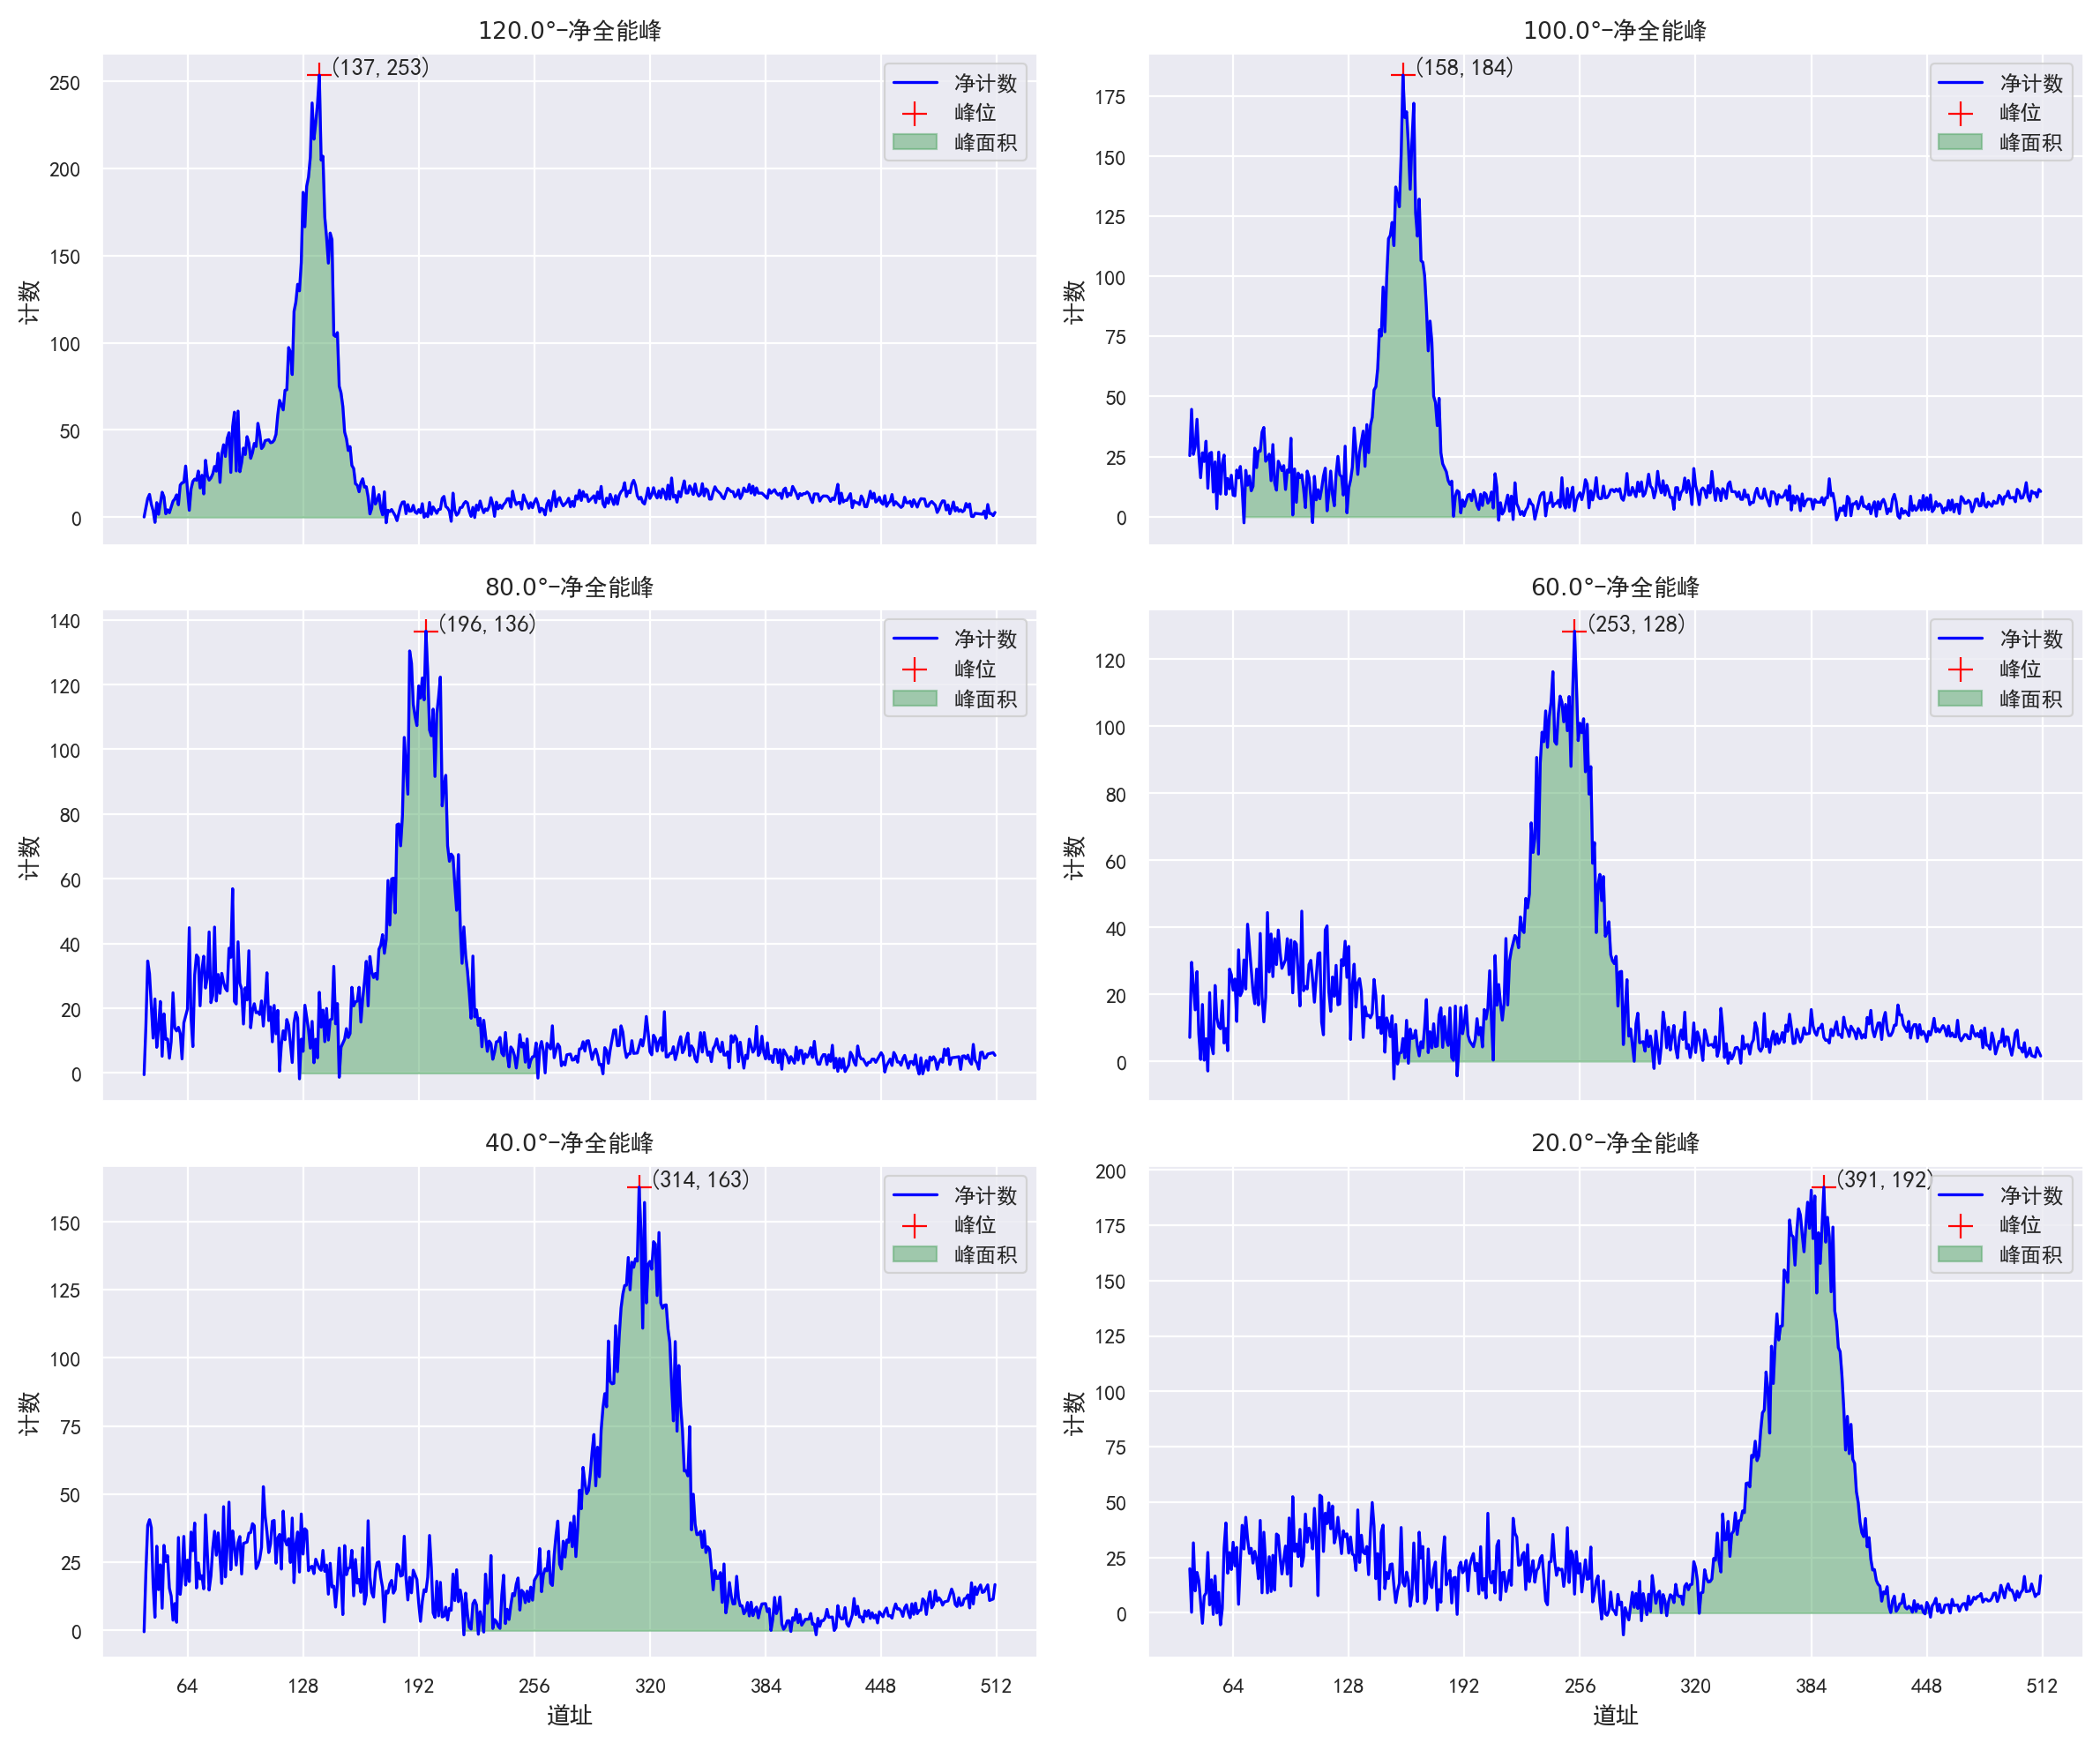

In [222]:
NET_axes = Net_Full_Energy.plot(subplots=True,layout=[3,2],figsize=(12,10),color='blue')
NET_axes = NET_axes.flatten()
heights = [100]*6
prominences = [200,150,120,120,140,160]


areas = []
peak_chennels = []
for ax,column,height,prominence in zip(NET_axes,Net_Full_Energy.columns,heights,prominences):
    peaks,info = find_peaks(Net_Full_Energy[column],
            height=height,
            prominence=prominence)
    peak_chennels.append(Net_Full_Energy.index[peaks[0]])
    sns.scatterplot(Net_Full_Energy.iloc[peaks],
                    x=Net_Full_Energy.index[peaks],
                    y=column,ax=ax,
                    label='Peak',color='red',marker='+',s=100)
    ax.text(Net_Full_Energy.index[peaks[0]]+5,
                 info['peak_heights'][0],
                 f'({Net_Full_Energy.index[peaks[0]]},{info['peak_heights'][0]:.0f})')
    low_index = Net_Full_Energy.index[info['left_bases']][0]
    high_index = Net_Full_Energy.index[info['right_bases']][0]
    fill_interval = np.arange(low_index,high_index,1)
    ax.fill_between(fill_interval,
                    0,
                    Net_Full_Energy[column][fill_interval],
                    color='g',alpha=0.5,label='Peak Area')
    areas.append(np.trapz(Net_Full_Energy[column][fill_interval]))

for ax,column in zip(NET_axes,datas_Full_Energy.columns[:6]):
    ax.legend(['净计数','峰位','峰面积'])
    ax.set_title(column+'-净全能峰')
    ax.set_ylabel('计数')

NET_axes[-1].set_xlabel('道址')
NET_axes[-2].set_xlabel('道址')
NET_axes[0].set_xticks(np.linspace(64,512,8))


FE_result = pd.DataFrame({'angle':np.linspace(120,20,6),
                          'para':degs,
                          'peaks':peak_chennels,
                          'area':areas})

NET_fig = NET_axes[0].get_figure()
NET_fig.tight_layout()
NET_fig.savefig(path+'Full_Energy_Peak.pdf')

FE_result = FE_result.sort_values(['angle'])
FE_result

# 结果

In [223]:
FE_result['angle_rad'] = FE_result['angle'].values/180*np.pi

dis = 226 #mm
S_dect = 40*40 #mm

FE_result['energy']=dao_to_Ene(FE_result['peaks'])
FE_result['eta']=ene_to_eta(FE_result['energy'])
FE_result['Ratio']=ene_to_R(FE_result['energy'])

FE_result['effective area']=FE_result['area']/(FE_result['eta']*FE_result['Ratio'])
FE_result['relative_area'] = FE_result['effective area']/FE_result['effective area'][5]
FE_result

,angle,para,peaks,area,angle_rad,energy,eta,Ratio,effective area,relative_area
5,20.0,2,391,9413.892215,0.349066,0.619785,0.001114,0.414987,2.035663e+07,1.000000
4,40.0,4,314,8113.086885,0.698132,0.494763,0.001236,0.495265,1.325677e+07,0.651226
3,60.0,4,253,5171.011000,1.047198,0.395720,0.001356,0.592557,6.434947e+06,0.316111
2,80.0,4,196,5190.572381,1.396263,0.303172,0.001523,0.718802,4.741590e+06,0.232926
1,100.0,5,158,5580.392169,1.745329,0.241473,0.001668,0.815858,4.101768e+06,0.201495
0,120.0,3,137,7505.857205,2.094395,0.207376,0.001738,0.871867,4.954741e+06,0.243397


In [232]:
formatters = {'angle':lambda x: f'{x:.1f}',
              'energy':lambda x:f'{x:.3f}',
              'area':lambda x: f'{x:.1f}',
              'eta':lambda x: f'{x*1e3:.3f}',
              'Ratio':lambda x: f'{x:.4f}',
              'relative_area':lambda x:f'{x:.3f}'}
columns = ['angle','para','peaks','area','energy','Ratio','eta','relative_area']
header =  ['角度','基线参数deg','峰位值','峰面积',r'能量(\unit{{MeV}})',r'峰总比($\times\num{{e-2}}$)','源探测效率','相对计数值']
print(FE_result.to_latex(header=header,
                         columns=columns,
                         formatters=formatters,
                         index=False,
                         column_format='c'*len(columns),
                         caption=r'测量微分散射截面不同角度的入射能谱数据处理结果',
                         label='tab:FE_result',
                         position='H'))

\begin{table}[H]
\caption{测量微分散射截面不同角度的入射能谱数据处理结果}
\label{tab:FE_result}
\begin{tabular}{cccccccc}
\toprule
角度 & 基线参数deg & 峰位值 & 峰面积 & 能量(\unit{MeV}) & 峰总比($\times\num{e-2}$) & 源探测效率 & 相对计数值 \\
\midrule
20.0 & 2 & 391 & 9413.9 & 0.620 & 1.114 & 0.4150 & 1.000 \\
40.0 & 4 & 314 & 8113.1 & 0.495 & 1.236 & 0.4953 & 0.651 \\
60.0 & 4 & 253 & 5171.0 & 0.396 & 1.356 & 0.5926 & 0.316 \\
80.0 & 4 & 196 & 5190.6 & 0.303 & 1.523 & 0.7188 & 0.233 \\
100.0 & 5 & 158 & 5580.4 & 0.241 & 1.668 & 0.8159 & 0.201 \\
120.0 & 3 & 137 & 7505.9 & 0.207 & 1.738 & 0.8719 & 0.243 \\
\bottomrule
\end{tabular}
\end{table}



## 能量曲线

,angle,Theoritical Energy,Experimental Energy,relative error %
5,20.0,0.614027,0.619785,0.937719
4,40.0,0.508023,0.494763,2.610090
3,60.0,0.401760,0.395720,1.503222
2,80.0,0.319723,0.303172,5.176753
1,100.0,0.262650,0.241473,8.062824
0,120.0,0.224921,0.207376,7.800461


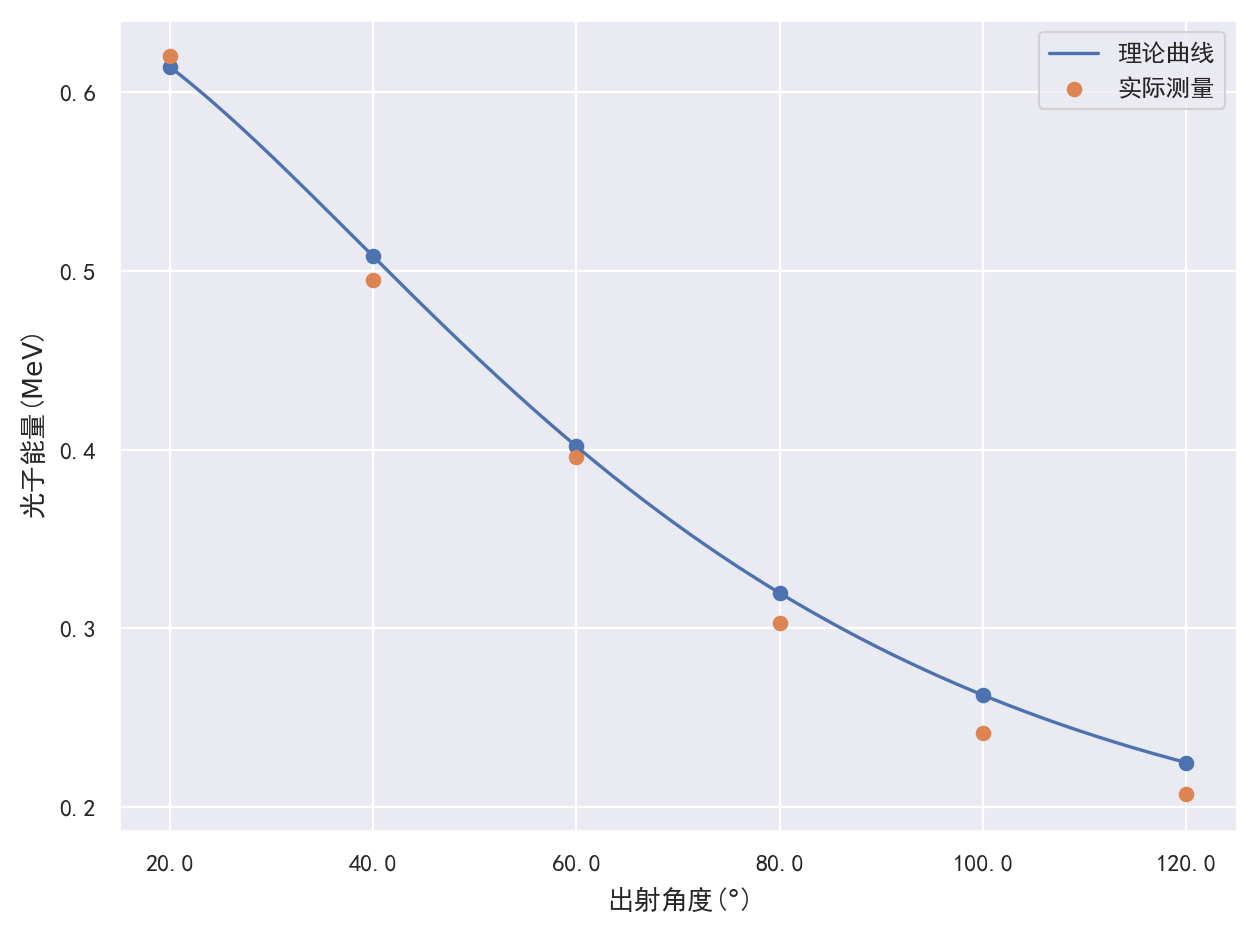

In [239]:
the_ene = gamma_out_ratio(FE_result['angle_rad'].values,Ene_Cs137)*Ene_Cs137
angle_plot_list = np.linspace(20,120,10001)/180*np.pi
ene_plot_list = gamma_out_ratio(angle_plot_list,Ene_Cs137)*Ene_Cs137


ax_Ene = plt.subplot()
ax_Ene.plot(angle_plot_list,ene_plot_list,label='理论曲线')
ax_Ene.scatter(FE_result['angle_rad'],the_ene)
ax_Ene.scatter(FE_result['angle_rad'],FE_result['energy'].values*u.MeV,label='实际测量')
interval_number = 5
ax_Ene.set_xticks(np.linspace(20,120,interval_number+1)/180*np.pi,
                  np.linspace(20,120,interval_number+1))
ax_Ene.set_xlabel(r'出射角度($\degree$)')
ax_Ene.set_ylabel(r'光子能量(${\rm MeV}$)')
ax_Ene.legend()
fig = ax_Ene.get_figure()
fig.tight_layout()
fig.savefig(path+'ene_result.pdf')

ene_result = pd.DataFrame({'angle':FE_result['angle'],
                           'Theoritical Energy':the_ene,
                           'Experimental Energy':FE_result['energy']})
ene_result['relative error %'] = np.abs(ene_result['Experimental Energy']\
                                      -ene_result['Theoritical Energy'])\
                                        /ene_result['Theoritical Energy']*100
ene_result

In [236]:
formatters = {'angle':lambda x: f'{x:.1f}',
              'Theoritical Energy':lambda x: f'{x:.3f}',
              'Experimental Energy':lambda x: f'{x:.3f}',
              'relative error %':lambda x: f'{x:.2f}'}
header =  ['角度',r'理论值(\unit{{MeV}})',r'测量值(\unit{{MeV}})',r'相对误差(\%)']
print(ene_result.to_latex(header=header,
                         formatters=formatters,
                         index=False,
                         column_format='c'*len(header),
                         caption='不同角度的入射能量',
                         label='tab:ene_result',
                         position='H'))

\begin{table}[H]
\caption{不同角度的入射能量}
\label{tab:ene_result}
\begin{tabular}{cccc}
\toprule
角度 & 理论值(\unit{MeV}) & 测量值(\unit{MeV}) & 相对误差(\%) \\
\midrule
20.0 & 0.614 & 0.620 & 0.94 \\
40.0 & 0.508 & 0.495 & 2.61 \\
60.0 & 0.402 & 0.396 & 1.50 \\
80.0 & 0.320 & 0.303 & 5.18 \\
100.0 & 0.263 & 0.241 & 8.06 \\
120.0 & 0.225 & 0.207 & 7.80 \\
\bottomrule
\end{tabular}
\end{table}



## 微分截面

,angle,Theoritical Cross Section,Experimental Cross Section,relative error %
5,20.0,1.000000,1.000000,0.000000
4,40.0,0.600675,0.651226,8.415765
3,60.0,0.341060,0.316111,7.315248
2,80.0,0.227340,0.232926,2.457062
1,100.0,0.188655,0.201495,6.806059
0,120.0,0.179955,0.243397,35.254299


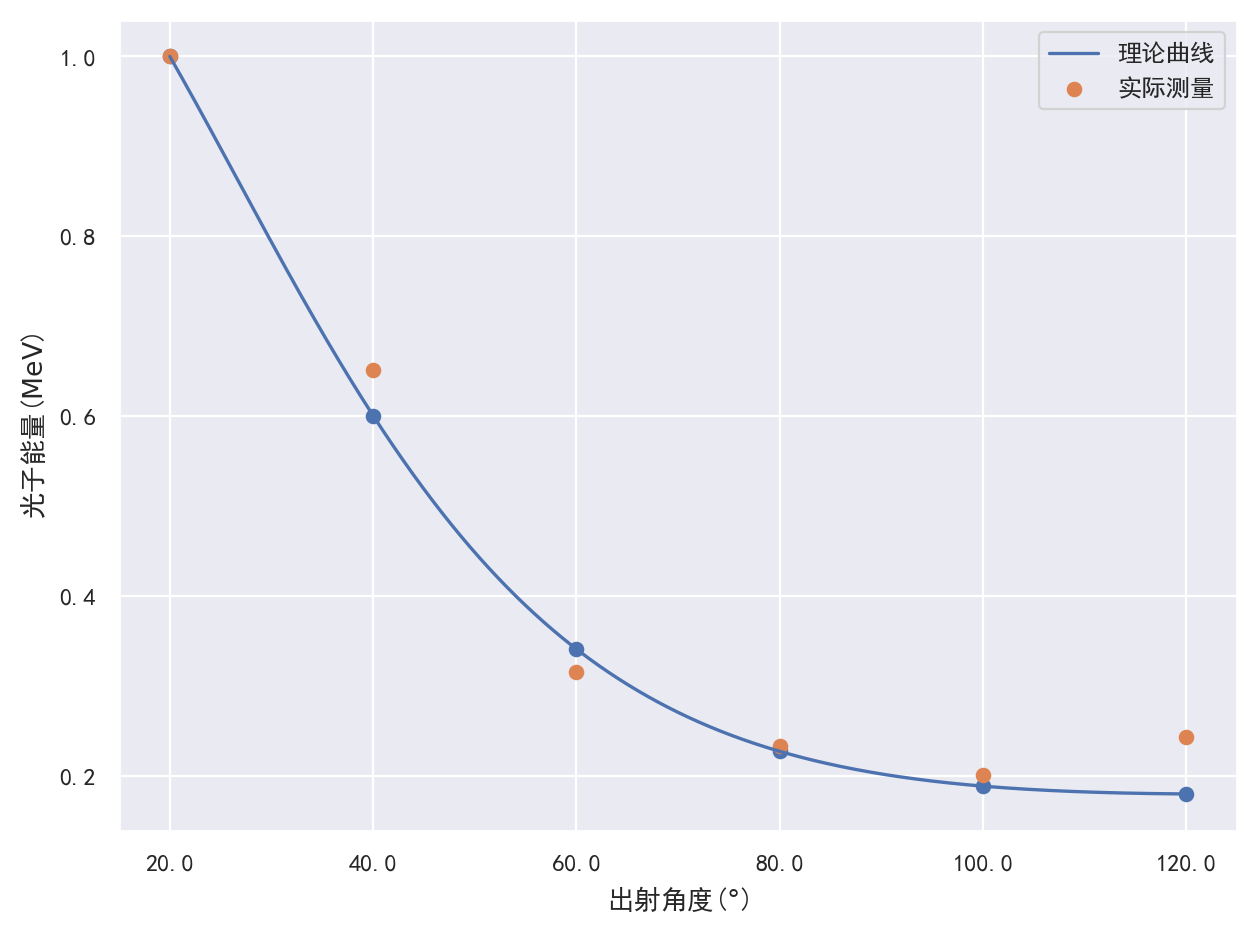

In [240]:
# angle_plot_list = np.linspace(20,120,10001)/180*np.pi
crs_plot_list = Klein_Nishin_formula(angle_plot_list,Ene_Cs137)
retv_crs_plot_list = crs_plot_list/Klein_Nishin_formula(20/180*np.pi,Ene_Cs137)

the_crs = Klein_Nishin_formula(FE_result['angle_rad'].values,Ene_Cs137)
retv_the_crs = the_crs/the_crs[0]

crs_Ene = plt.subplot()
crs_Ene.plot(angle_plot_list,retv_crs_plot_list,label='理论曲线')
crs_Ene.scatter(FE_result['angle_rad'],retv_the_crs)
crs_Ene.scatter(FE_result['angle_rad'],FE_result['relative_area'],label='实际测量')
# interval_number = 5
crs_Ene.set_xticks(np.linspace(20,120,interval_number+1)/180*np.pi,
                  np.linspace(20,120,interval_number+1))
crs_Ene.legend()
crs_Ene.set_xlabel(r'出射角度($\degree$)')
crs_Ene.set_ylabel(r'光子能量(${\rm MeV}$)')
crs_Ene.legend()
fig = crs_Ene.get_figure()
fig.tight_layout()
fig.savefig(path+'crs_result.pdf')


crs_result = pd.DataFrame({'angle':FE_result['angle'],
                           'Theoritical Cross Section':retv_the_crs,
                           'Experimental Cross Section':FE_result['relative_area']})
crs_result['relative error %'] = np.abs(crs_result['Experimental Cross Section']\
                                        -crs_result['Theoritical Cross Section'])\
                                        /crs_result['Theoritical Cross Section']*100
crs_result

In [245]:
formatters = {'angle':lambda x: f'{x:.1f}',
              'Theoritical Cross Section':lambda x: f'{x:.3f}',
              'Experimental Cross Section':lambda x: f'{x:.3f}',
              'relative error %':lambda x: f'{x:.2f}'}
header =  ['角度',r'理论值',r'测量值',r'相对误差(\%)']
print(crs_result.to_latex(header=header,
                         formatters=formatters,
                         index=False,
                         column_format='c'*len(header),
                         caption='不同角度的相对微分散射截面',
                         label='tab:crs_result',
                         position='H'))

\begin{table}[H]
\caption{不同角度的相对微分散射截面}
\label{tab:crs_result}
\begin{tabular}{cccc}
\toprule
角度 & 理论值 & 测量值 & 相对误差(\%) \\
\midrule
20.0 & 1.000 & 1.000 & 0.00 \\
40.0 & 0.601 & 0.651 & 8.42 \\
60.0 & 0.341 & 0.316 & 7.32 \\
80.0 & 0.227 & 0.233 & 2.46 \\
100.0 & 0.189 & 0.201 & 6.81 \\
120.0 & 0.180 & 0.243 & 35.25 \\
\bottomrule
\end{tabular}
\end{table}

